# Download OW polygons from a specific polygon set via DSIS

This notebook provides a simple workflow for sending a request to DSIS using the `dsis-client` library developed by Equinor.

The following steps are covered:

1. Authenticate to DSIS using an `.env_dsis` file with the required configuration and credentials.
2. Construct and execute a query requesting polygons belonging to a specific polygon set.
3. Visualize the results returned by the query.

For more information about the required content of the `.env_dsis` file, please contact the SDD-SID team, or the DSIS team in Equinor.

In [1]:
from dotenv import load_dotenv
import os
from typing import Any
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import json

from dsis_client import DSISClient, DSISConfig, QueryBuilder, Environment

### Authenticate and connect to DSIS

We need to specify the name and version of the model we plan to use, as currently the `dsis-client` library requires these parameters when building the ``DSISConfig`` object. This might be later on moved to the query building step.

In [2]:
MODEL_NAME = "OpenWorksCommonModel"
MODEL_VERSION = "5000107"

Next, we provide all the other required configuration and credentials via the `.env_dsis` file. Make sure to modify the `config` logic below if you are, e.g., fetching secrets from a key vault through this notebook.

In [3]:
load_dotenv(".env_dsis")

True

In [4]:
config = DSISConfig(
    environment=Environment.DEV,
    tenant_id=os.getenv("tenant_id"),
    client_id=os.getenv("client_id"),
    client_secret=os.getenv("client_secret"),
    access_app_id=os.getenv("resource_id"),
    dsis_username=os.getenv("dsis_function_key"),
    dsis_password=os.getenv("dsis_password"),
    subscription_key_dsauth=os.getenv("subscription_key_dsauth"),
    subscription_key_dsdata=os.getenv("subscription_key_dsdata"),
    model_name=MODEL_NAME,
    model_version=MODEL_VERSION,
    dsis_site=os.getenv("dsis_site"),
)

In [5]:
dsis_client = DSISClient(config)
if dsis_client.test_connection():
    print("✓ Connected to DSIS API")

✓ Connected to DSIS API


### Build and execute a query

Here, we can specify the OW database and project, as well as the object id of the data we want to download. In this notebook, we download polygons (MappingPolygon objects) belonging to a specific polygon set (MappingPolygonSet), and the `OBJECT_ID` corresponds to the polygon set id that we filter by.

In [6]:
DISTRICT = "BG4FROST"
PROJECT = "VOLVE_PUBLIC"
OBJECT_ID = 2326

In [ ]:
# Helper function which might be incorporated in the dsis-client library in the future


def build_district_id(database: str, *, model_name: str) -> str:
    """Build DSIS district_id from database name.

    DSIS uses different district-id conventions for different models.

    Examples:
    - OpenWorksCommonModel: OpenWorksCommonModel_OW_<DB>-OW_<DB>
    - OpenWorks native models (e.g., OW5000): OpenWorks_OW_<DB>_SingleSource-OW_<DB>
    """
    if model_name == "OpenWorksCommonModel":
        return f"OpenWorksCommonModel_OW_{database}-OW_{database}"
    return f"OpenWorks_OW_{database}_SingleSource-OW_{database}"

We build a query, specyfying the district (OW database), project and schema (DSIS endpoint exposed in the model selected earlier). We additionally filter by the polygon set id.

In [8]:
query = (
    QueryBuilder(
        district_id=build_district_id(DISTRICT, model_name=config.model_name),
        project=PROJECT,
    )
    .schema("MappingPolygon")
    .filter(f"mappingpolygonset_native_uid eq '{OBJECT_ID}'")
)

We execute the query and print out the first element from the list returned in the response from DSIS. This element correponds to a single polygon.

In [9]:
query_results: list[dict[str, Any]] = list(dsis_client.execute_query(query))

In [10]:
print(json.dumps(query_results[0], indent=4))

{
    "datum": 0,
    "color": null,
    "data": {
        "x_coord": [
            435259.53,
            435219.94,
            435181.06,
            435163.38,
            435115.3,
            435096.22,
            435070.06,
            435025.53,
            434991.6,
            434966.84,
            434945.62,
            434932.3,
            434908.28,
            434889.88,
            434869.53,
            434858.94,
            434834.2,
            434876.47,
            434901.9,
            434912.5,
            434930.06,
            434949.16,
            434977.44,
            435019.16,
            435045.3,
            435074.3,
            435103.28,
            435135.1,
            435154.2,
            435172.6,
            435210.75,
            435251.75,
            435332.8,
            435323.88,
            435259.53
        ],
        "y_coord": [
            6479503.5,
            6479501,
            6479502,
            6479498.5,
            6479

Finally, we can plot all the polygons returned by DSIS using the `query` above.

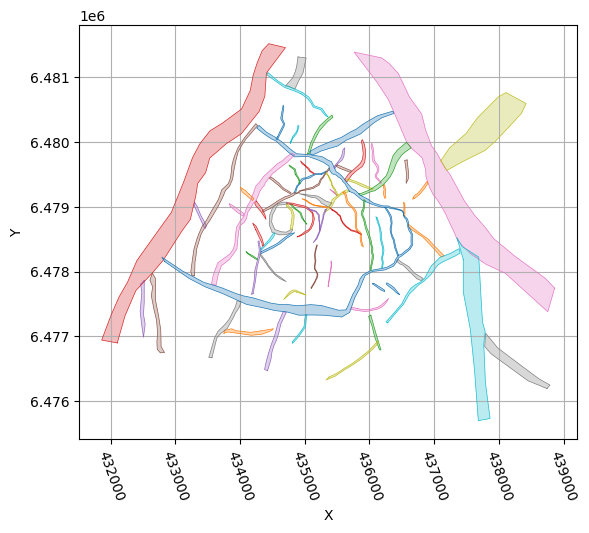

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))

# Plot each polygon from query_results
for i, result in enumerate(query_results):
    spatial = result["spatial"]
    x_coords = [float(x) for x in spatial["x"]]
    y_coords = [float(y) for y in spatial["y"]]

    polygon = Polygon(zip(x_coords, y_coords))
    x, y = polygon.exterior.xy
    ax.plot(x, y, linewidth=0.5)
    ax.fill(x, y, alpha=0.3)

ax.set_aspect("equal")
ax.grid(True)
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.xticks(rotation=-70)
plt.tight_layout()
plt.show()